In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
pd.options.mode.chained_assignment = None 
from matplotlib import pyplot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
import pickle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate, cross_val_score, KFold
pd.set_option('display.max_columns', None)

# Preparing for modelling on a specific route

In [58]:
df = pd.read_csv("Cleaned_By_Route_Header/route_120.csv")

In [59]:
df

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,MONTH,DAY,Quarter,ARRIVAL_TIME_ACTUAL,DEPARTURE_TIME_ACTUAL,DWELL_TIME,LINEID,ROUTEID,DIRECTION
0,2018-01-01,5958062,1,6004,70200,70200,70206,70206,1001212,1,0,1,19:30:06,19:30:06,0,120,120_7,1
1,2018-01-01,5958062,2,3,70288,70288,70269,70318,1001212,1,0,1,19:31:09,19:31:58,49,120,120_7,1
2,2018-01-01,5958062,3,192,70502,70502,70401,70415,1001212,1,0,1,19:33:21,19:33:35,14,120,120_7,1
3,2018-01-01,5958062,4,795,70531,70531,70444,70444,1001212,1,0,1,19:34:04,19:34:04,0,120,120_7,1
4,2018-01-01,5958062,5,796,70565,70565,70459,70459,1001212,1,0,1,19:34:19,19:34:19,0,120,120_7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813827,2018-12-31,8591323,20,817,25955,25955,26170,26181,2693257,12,0,4,07:16:10,07:16:21,11,120,120_13,2
813828,2018-12-31,8591323,21,818,25980,25980,26200,26200,2693257,12,0,4,07:16:40,07:16:40,0,120,120_13,2
813829,2018-12-31,8591323,22,819,26040,26040,26243,26262,2693257,12,0,4,07:17:23,07:17:42,19,120,120_13,2
813830,2018-12-31,8591323,23,263,26118,26118,26332,26356,2693257,12,0,4,07:18:52,07:19:16,24,120,120_13,2


In [60]:
df.dtypes

DAYOFSERVICE             object
TRIPID                    int64
PROGRNUMBER               int64
STOPPOINTID               int64
PLANNEDTIME_ARR           int64
PLANNEDTIME_DEP           int64
ACTUALTIME_ARR            int64
ACTUALTIME_DEP            int64
VEHICLEID                 int64
MONTH                     int64
DAY                       int64
Quarter                   int64
ARRIVAL_TIME_ACTUAL      object
DEPARTURE_TIME_ACTUAL    object
DWELL_TIME                int64
LINEID                    int64
ROUTEID                  object
DIRECTION                 int64
dtype: object

In [61]:
#convert to appropriate data types
df['DAYOFSERVICE'] = df['DAYOFSERVICE'].astype('datetime64[ns]')
df['ROUTEID'] = df['ROUTEID'].astype('category')
df['LINEID'] = df['LINEID'].astype('category')

In [62]:
#adding an hour column so that dataframe can be merged with weather dataframe 
df['HOUR'] = pd.to_datetime(df['DEPARTURE_TIME_ACTUAL'])
df['HOUR'] = df['HOUR'].dt.hour

In [63]:
#Grouping the trips by day of service and trip ID and then 
#sorting the dataframe according to progrnumber (Sequential position of the stop point in the trip)
sorted_df = df.groupby(["DAYOFSERVICE","TRIPID"]).apply(lambda x: x.sort_values(["PROGRNUMBER"], ascending = True)).reset_index(drop=True)

In [64]:
#Creating a feature for the duration of the journey 
#this is done by taking the actual departure time of the preceding row from the arrival time of the following row.
sorted_df['JOURNEY_DURATION'] = sorted_df['ACTUALTIME_ARR'].shift(-1) - sorted_df['ACTUALTIME_DEP'] 

In [65]:
#creating the peak hour feature
sorted_df['PEAK_HOUR'] = [1 if x >'07:00:00' and x <'10:00:00' or x >'16:00:00' and x <'19:00:00' else 0 for x in sorted_df['ARRIVAL_TIME_ACTUAL']]

In [66]:
#creating a holiday indicator feature for dates of holidays and observances that would have effected bus journey times
dates = pd.to_datetime(['2018-01-01','2018-03-17','2018-03-19','2018-03-30','2018-04-01','2018-04-02','2018-05-07',
 '2018-06-04','2018-08-06','2018-11-29','2018-12-24','2018-12-25','2018-12-26', '2018-12-31'])

sorted_df['HOLIDAY'] = sorted_df['DAYOFSERVICE'].isin(dates)
sorted_df['HOLIDAY'] *= 1

In [116]:
sorted_df

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,MONTH,DAY,Quarter,DWELL_TIME,LINEID,ROUTEID,DIRECTION,HOUR,JOURNEY_DURATION,PEAK_HOUR,PUBLIC_HOLIDAY,NEXT_STOPPOINTID,NEXT_PROGNUMBER,END_OF_TRIP
0,2018-01-01,5955815,1,6004,36105,36105,1001212,1,0,1,0,120,120_7,1,10,30.0,0,1,3.0,2.0,1.0
1,2018-01-01,5955815,2,3,36135,36151,1001212,1,0,1,16,120,120_7,1,10,79.0,0,1,192.0,3.0,1.0
2,2018-01-01,5955815,3,192,36230,36230,1001212,1,0,1,0,120,120_7,1,10,22.0,0,1,795.0,4.0,1.0
3,2018-01-01,5955815,4,795,36252,36252,1001212,1,0,1,0,120,120_7,1,10,5.0,0,1,796.0,5.0,1.0
4,2018-01-01,5955815,5,796,36257,36257,1001212,1,0,1,0,120,120_7,1,10,83.0,0,1,56.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813826,2018-12-31,8591329,19,82,42625,42642,2693257,12,0,4,17,120,120_13,2,11,38.0,0,0,817.0,20.0,1.0
813827,2018-12-31,8591329,20,817,42680,42680,2693257,12,0,4,0,120,120_13,2,11,18.0,0,0,818.0,21.0,1.0
813828,2018-12-31,8591329,21,818,42698,42709,2693257,12,0,4,11,120,120_13,2,11,101.0,0,0,819.0,22.0,1.0
813829,2018-12-31,8591329,22,819,42810,42810,2693257,12,0,4,0,120,120_13,2,11,73.0,0,0,263.0,23.0,1.0


In [67]:
#deleting columns that won't be used
del sorted_df['ARRIVAL_TIME_ACTUAL']
del sorted_df['DEPARTURE_TIME_ACTUAL']
del sorted_df['PLANNEDTIME_DEP']
del sorted_df['PLANNEDTIME_ARR']

In [68]:
#we want to get rid of all rows where the bus has reached the final destination of the trip
#the journey duration of these rows is not representative of the actual journey time as 
#this is the time spent in the bay before the next trip 

#we create a column END_OF_TRIP that will be 1 for all in transit journeys
#and negative for the final destination as it is the subtraction of the progress number of the current section
#from the progress number of the next section of the trip 
sorted_df['NEXT_STOPPOINTID'] = sorted_df['STOPPOINTID'].shift(-1)
sorted_df['NEXT_PROGNUMBER']=sorted_df["PROGRNUMBER"].shift(-1)
sorted_df['END_OF_TRIP'] = sorted_df['NEXT_PROGNUMBER'] - sorted_df['PROGRNUMBER']

In [69]:
#as the final rows journey duration, NEXT_STOPPOINTID, NEXT_PROGNUMBER and END_OF_TRIP are null
sorted_df = sorted_df.dropna(axis=0)

In [70]:
sorted_df.dtypes

DAYOFSERVICE        datetime64[ns]
TRIPID                       int64
PROGRNUMBER                  int64
STOPPOINTID                  int64
ACTUALTIME_ARR               int64
ACTUALTIME_DEP               int64
VEHICLEID                    int64
MONTH                        int64
DAY                          int64
Quarter                      int64
DWELL_TIME                   int64
LINEID                    category
ROUTEID                   category
DIRECTION                    int64
HOUR                         int64
JOURNEY_DURATION           float64
PEAK_HOUR                    int64
PUBLIC_HOLIDAY               int64
NEXT_STOPPOINTID           float64
NEXT_PROGNUMBER            float64
END_OF_TRIP                float64
dtype: object

# Merging weather data 

In [71]:
weather_df = pd.read_csv('Clean_Weather_2018.csv')

In [72]:
weather_df

,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,date,hour
0,4.15,990,87,12.86,240,40,Rain,2018-01-01,0
1,4.14,991,87,11.83,240,75,Rain,2018-01-01,1
2,4.61,990,81,12.35,240,40,Clouds,2018-01-01,2
3,4.64,990,81,12.35,240,40,Clouds,2018-01-01,3
4,5.04,990,81,11.83,240,40,Clouds,2018-01-01,4
...,...,...,...,...,...,...,...,...,...
8795,9.65,1034,76,4.10,260,75,Clouds,2018-12-31,19
8796,9.27,1034,81,4.10,250,75,Clouds,2018-12-31,20
8797,9.31,1034,81,5.10,260,75,Clouds,2018-12-31,21
8798,9.19,1035,81,5.70,260,75,Clouds,2018-12-31,22


In [73]:
weather_df.dtypes

temp            float64
pressure          int64
humidity          int64
wind_speed      float64
wind_deg          int64
clouds_all        int64
weather_main     object
date             object
hour              int64
dtype: object

In [74]:
weather_df['date'] = weather_df['date'].astype('datetime64[ns]')
weather_df['weather_main'] = weather_df['weather_main'].astype('category')

In [75]:
weather_df

,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,date,hour
0,4.15,990,87,12.86,240,40,Rain,2018-01-01,0
1,4.14,991,87,11.83,240,75,Rain,2018-01-01,1
2,4.61,990,81,12.35,240,40,Clouds,2018-01-01,2
3,4.64,990,81,12.35,240,40,Clouds,2018-01-01,3
4,5.04,990,81,11.83,240,40,Clouds,2018-01-01,4
...,...,...,...,...,...,...,...,...,...
8795,9.65,1034,76,4.10,260,75,Clouds,2018-12-31,19
8796,9.27,1034,81,4.10,250,75,Clouds,2018-12-31,20
8797,9.31,1034,81,5.10,260,75,Clouds,2018-12-31,21
8798,9.19,1035,81,5.70,260,75,Clouds,2018-12-31,22


In [76]:
final_df = pd.merge(sorted_df, weather_df, how='left',left_on=['DAYOFSERVICE','HOUR'],right_on=['date','hour'])

In [77]:
del final_df['VEHICLEID']
del final_df['date']
del final_df['hour']

In [78]:
final_df.dtypes

DAYOFSERVICE        datetime64[ns]
TRIPID                       int64
PROGRNUMBER                  int64
STOPPOINTID                  int64
ACTUALTIME_ARR               int64
ACTUALTIME_DEP               int64
MONTH                        int64
DAY                          int64
Quarter                      int64
DWELL_TIME                   int64
LINEID                    category
ROUTEID                   category
DIRECTION                    int64
HOUR                         int64
JOURNEY_DURATION           float64
PEAK_HOUR                    int64
PUBLIC_HOLIDAY               int64
NEXT_STOPPOINTID           float64
NEXT_PROGNUMBER            float64
END_OF_TRIP                float64
temp                       float64
pressure                     int64
humidity                     int64
wind_speed                 float64
wind_deg                     int64
clouds_all                   int64
weather_main              category
dtype: object

In [79]:
final_df['MONTH']= final_df['MONTH'].astype('category')
final_df['DAY']= final_df['DAY'].astype('category')
final_df['HOUR']= final_df['HOUR'].astype('category')
final_df['STOPPOINTID']= final_df['STOPPOINTID'].astype('category')

final_df['NEXT_STOPPOINTID']= final_df['NEXT_STOPPOINTID'].astype('int')
final_df['NEXT_STOPPOINTID']= final_df['NEXT_STOPPOINTID'].astype('category')

final_df['JOURNEY_DURATION']= final_df['JOURNEY_DURATION'].astype('int')

In [80]:
# #creating the rain feature
final_df['Rain'] = [1 if x =='Rain' else 0 for x in final_df['weather_main']]
final_df['Rain']= final_df['Rain'].astype('category')

In [81]:
#removing the row at the end of each trip where journey duration is not required.
final_df = final_df.loc[final_df['END_OF_TRIP'] == 1]

In [82]:
final_df

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,ACTUALTIME_ARR,ACTUALTIME_DEP,MONTH,DAY,Quarter,DWELL_TIME,LINEID,ROUTEID,DIRECTION,HOUR,JOURNEY_DURATION,PEAK_HOUR,PUBLIC_HOLIDAY,NEXT_STOPPOINTID,NEXT_PROGNUMBER,END_OF_TRIP,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,Rain
0,2018-01-01,5955815,1,6004,36105,36105,1,0,1,0,120,120_7,1,10,30,0,1,3,2.0,1.0,5.02,992,81,9.77,240,40,Clouds,0
1,2018-01-01,5955815,2,3,36135,36151,1,0,1,16,120,120_7,1,10,79,0,1,192,3.0,1.0,5.02,992,81,9.77,240,40,Clouds,0
2,2018-01-01,5955815,3,192,36230,36230,1,0,1,0,120,120_7,1,10,22,0,1,795,4.0,1.0,5.02,992,81,9.77,240,40,Clouds,0
3,2018-01-01,5955815,4,795,36252,36252,1,0,1,0,120,120_7,1,10,5,0,1,796,5.0,1.0,5.02,992,81,9.77,240,40,Clouds,0
4,2018-01-01,5955815,5,796,36257,36257,1,0,1,0,120,120_7,1,10,83,0,1,56,6.0,1.0,5.02,992,81,9.77,240,40,Clouds,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816542,2018-12-31,8591329,19,82,42625,42642,12,0,4,17,120,120_13,2,11,38,0,0,817,20.0,1.0,9.82,1034,76,4.10,220,75,Clouds,0
816543,2018-12-31,8591329,20,817,42680,42680,12,0,4,0,120,120_13,2,11,18,0,0,818,21.0,1.0,9.82,1034,76,4.10,220,75,Clouds,0
816544,2018-12-31,8591329,21,818,42698,42709,12,0,4,11,120,120_13,2,11,101,0,0,819,22.0,1.0,9.82,1034,76,4.10,220,75,Clouds,0
816545,2018-12-31,8591329,22,819,42810,42810,12,0,4,0,120,120_13,2,11,73,0,0,263,23.0,1.0,9.82,1034,76,4.10,220,75,Clouds,0


In [83]:
#remove negative journey times
final_df = final_df[(final_df['JOURNEY_DURATION'] > 0)]

In [84]:
#remove outliers that are 3 standard deviations above the mean.
final_df=final_df[np.abs(final_df.JOURNEY_DURATION-final_df.JOURNEY_DURATION.mean()) <= (3*final_df.JOURNEY_DURATION.std())]

In [85]:
# #delete unused columns and those used for transormation and creation features 
# del final_df['PROGRNUMBER']
# del final_df['ACTUALTIME_ARR']
# del final_df['ACTUALTIME_DEP']
# del final_df['Quarter']
# del final_df['DWELL_TIME']
# del final_df['NEXT_PROGNUMBER']
# del final_df['END_OF_TRIP']
# del final_df['TRIPID']

In [86]:
final_df.dtypes

DAYOFSERVICE        datetime64[ns]
TRIPID                       int64
PROGRNUMBER                  int64
STOPPOINTID               category
ACTUALTIME_ARR               int64
ACTUALTIME_DEP               int64
MONTH                     category
DAY                       category
Quarter                      int64
DWELL_TIME                   int64
LINEID                    category
ROUTEID                   category
DIRECTION                    int64
HOUR                      category
JOURNEY_DURATION             int64
PEAK_HOUR                    int64
PUBLIC_HOLIDAY               int64
NEXT_STOPPOINTID          category
NEXT_PROGNUMBER            float64
END_OF_TRIP                float64
temp                       float64
pressure                     int64
humidity                     int64
wind_speed                 float64
wind_deg                     int64
clouds_all                   int64
weather_main              category
Rain                      category
dtype: object

- This gives us a final data frame that is ready for modelling, all of these steps will be placed within a function in a seperate notebook so that model testing can be done. 

- Next we will perform some feature analysis in order to decipher which features have a relationship with the target feature (journey time).

# Feature selection


# Plotting Pairwise Interactions to determine which features to keep 

In [87]:
Duplicate_df = final_df.copy()

In [88]:
#delete unused columns and those used for transormation and creation features 
del Duplicate_df['PROGRNUMBER']
del Duplicate_df['ACTUALTIME_ARR']
del Duplicate_df['ACTUALTIME_DEP']
del Duplicate_df['Quarter']
del Duplicate_df['DWELL_TIME']
del Duplicate_df['NEXT_PROGNUMBER']
del Duplicate_df['END_OF_TRIP']
del Duplicate_df['TRIPID']

In [89]:
Duplicate_df['DIRECTION']= Duplicate_df['DIRECTION'].astype('category')
Duplicate_df['PEAK_HOUR']= Duplicate_df['PEAK_HOUR'].astype('category')
Duplicate_df['HOLIDAY']= Duplicate_df['HOLIDAY'].astype('category')

In [90]:
continuous_columns = Duplicate_df.select_dtypes(['int64', 'float64']).columns

In [91]:
categorical_columns = Duplicate_df.select_dtypes(['category']).columns

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'JOURNEY_DURATION'),
  Text(1.5, 0, 'temp'),
  Text(2.5, 0, 'pressure'),
  Text(3.5, 0, 'humidity'),
  Text(4.5, 0, 'wind_speed'),
  Text(5.5, 0, 'wind_deg'),
  Text(6.5, 0, 'clouds_all')])

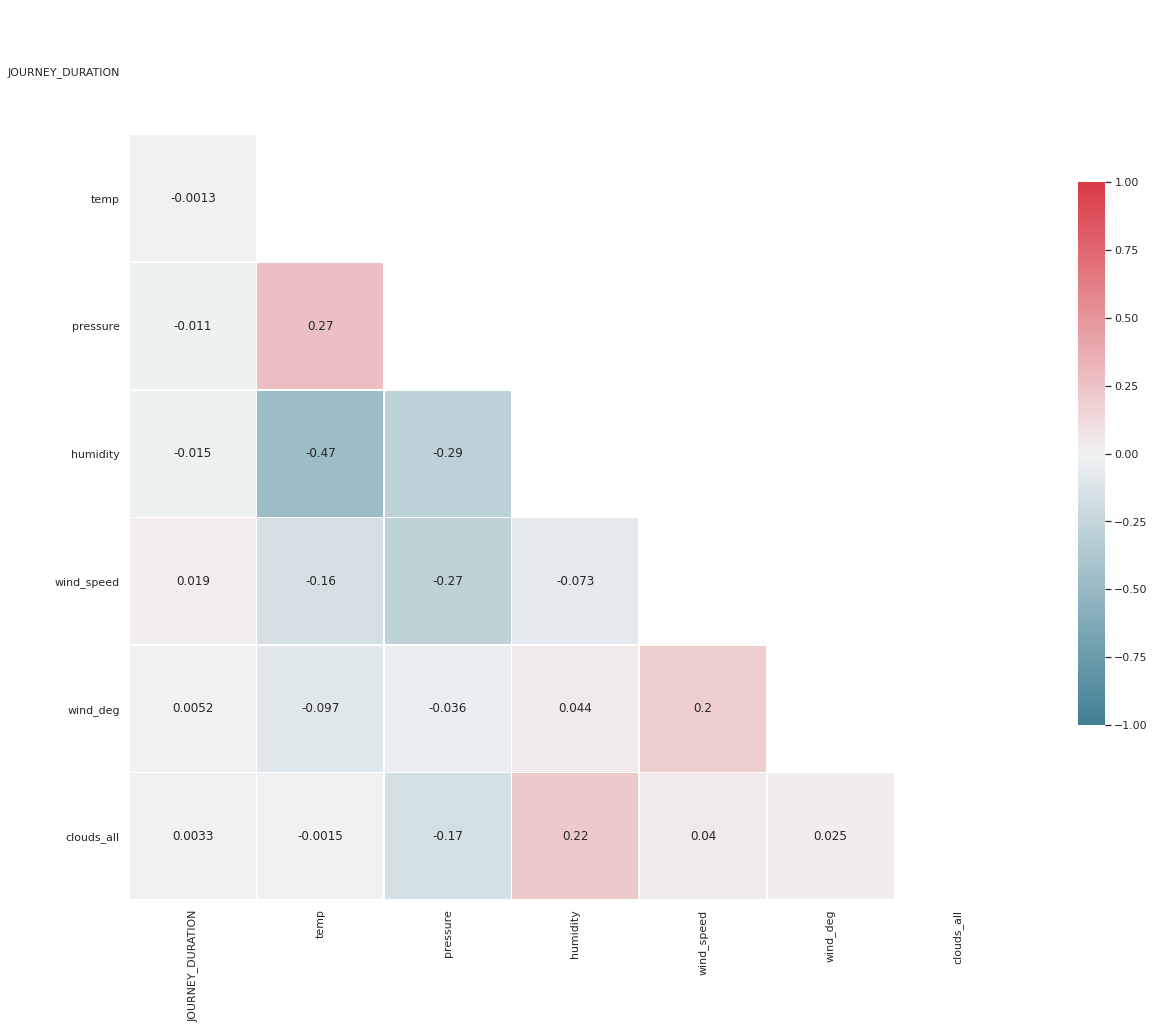

In [92]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = Duplicate_df[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

Overall it seems there are very weak correlations between the continuos features in the data. particularly the correlations with journey duration.

In [93]:
continuous_columns = continuous_columns.drop('JOURNEY_DURATION')

In [94]:
Y_duplicate = pd.DataFrame(Duplicate_df["JOURNEY_DURATION"])
X_duplicate = Duplicate_df.drop(["JOURNEY_DURATION"],1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,JOURNEY_DURATION
wind_speed,0.019344
wind_deg,0.005161
clouds_all,0.003317
temp,-0.001272
pressure,-0.011328
humidity,-0.015395


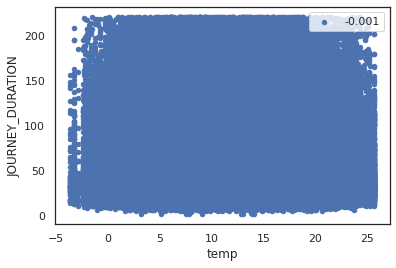

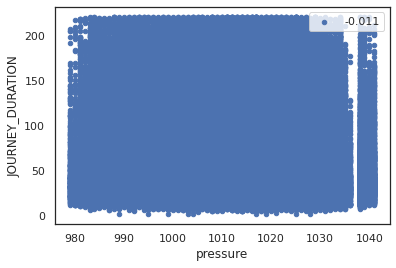

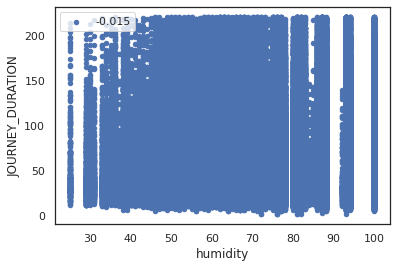

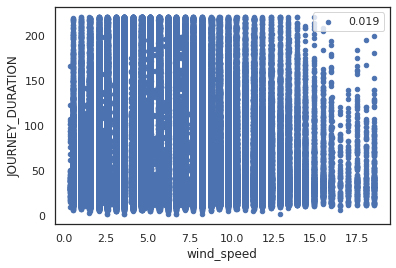

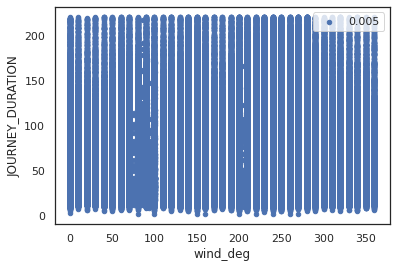

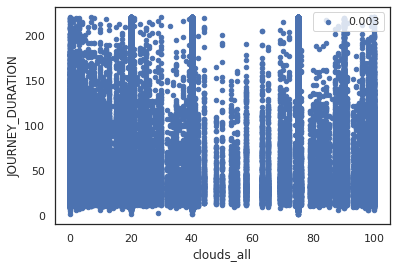

In [95]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_duplicate[continuous_columns]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_duplicate[column], Y_duplicate], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "JOURNEY_DURATION"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="JOURNEY_DURATION", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['JOURNEY_DURATION']).sort_values('JOURNEY_DURATION', ascending=False)
corr_df

In [96]:
#drop categorical features that were used as identifiers (LINEID, ROUTEID).
#and those whose relationship with the target feature we are not concerned with (STOPPOINTID, NEXT_STOPPOINTID).
drop = ['STOPPOINTID','NEXT_STOPPOINTID', 'LINEID','ROUTEID']
for column in drop: 
    categorical_columns = categorical_columns.drop(column)

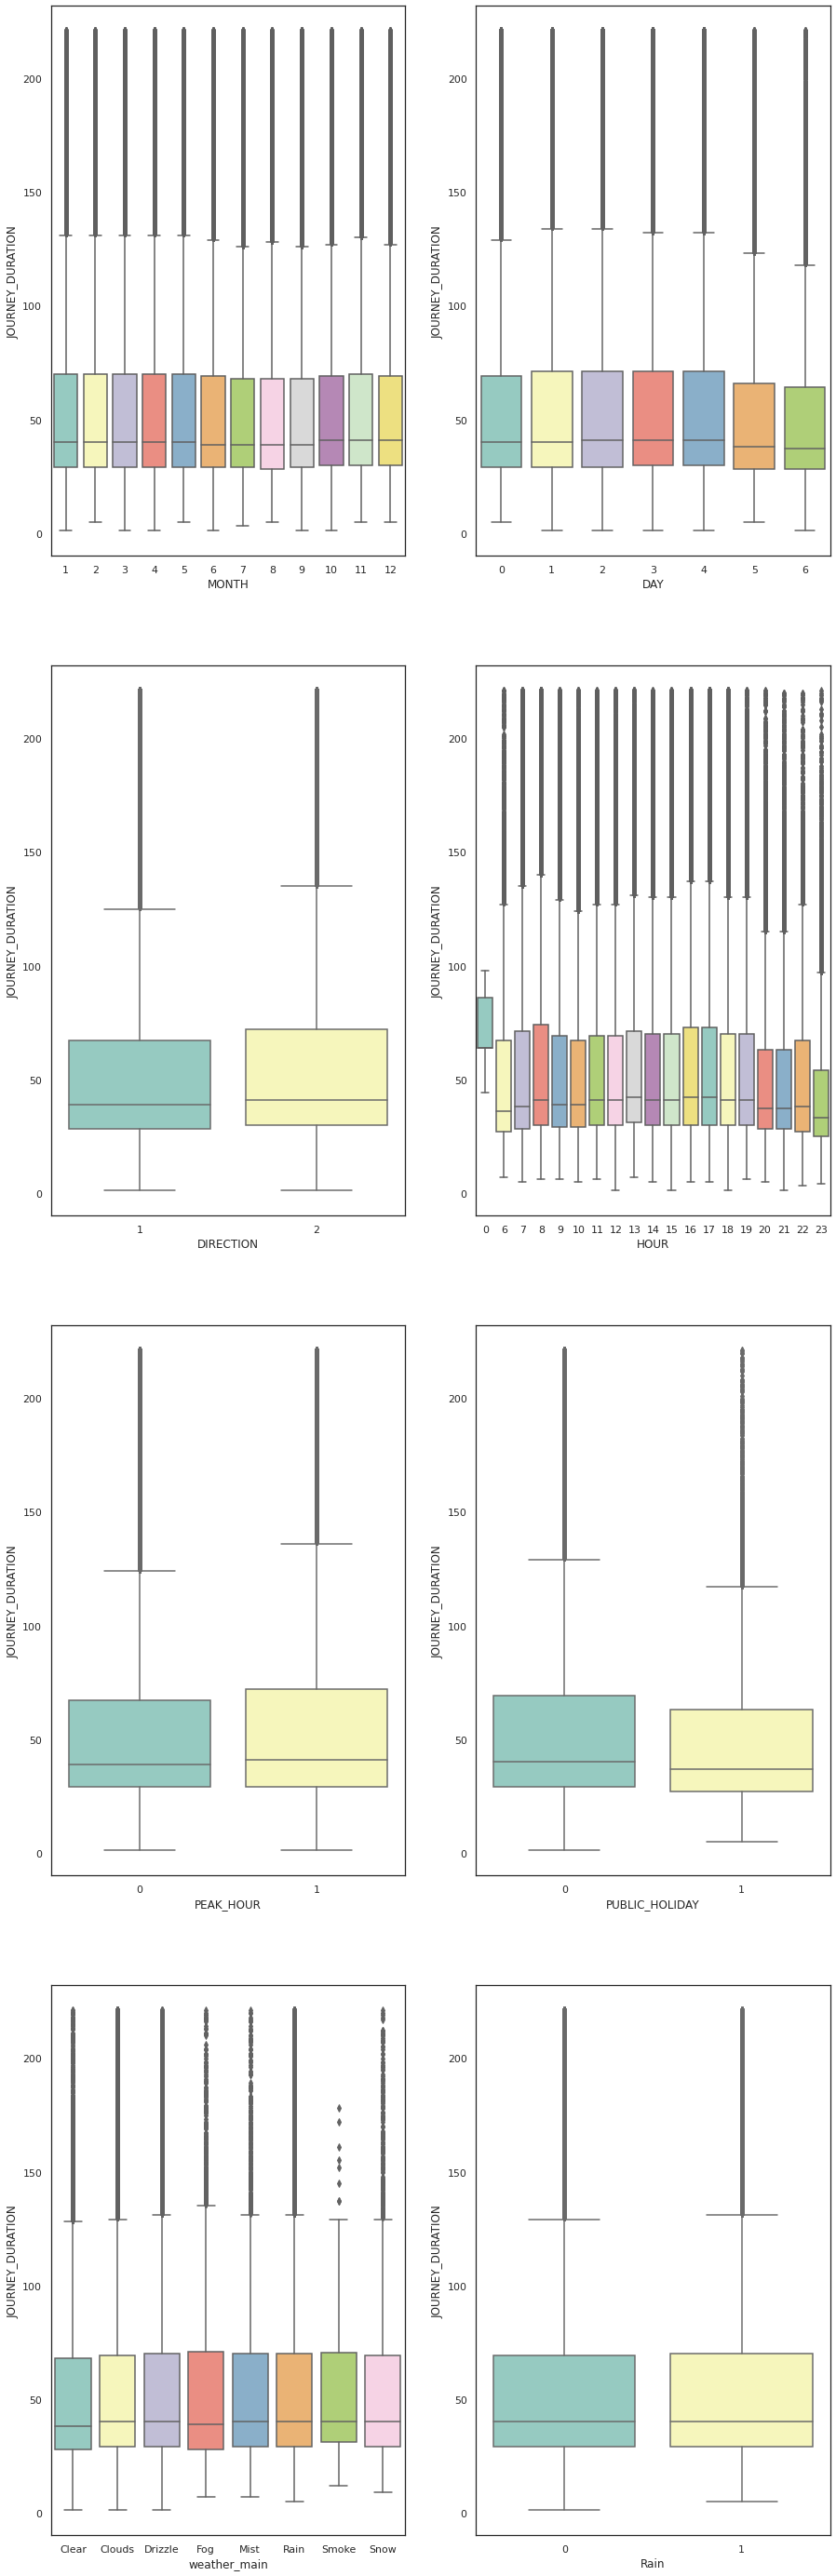

In [97]:
fig, ax = plt.subplots(4,2, figsize=(15, 50))
# plot pairwise interaction between all continuous features and target
for column, subplot in zip(X_duplicate[categorical_columns], ax.flatten()):
    # create temp df to merge column and target
    df_temp = pd.concat([X_duplicate[column], Y_duplicate], axis=1)

    # plot the column and tartget feature
    sns.boxplot(x=column, y='JOURNEY_DURATION', data=df_temp, ax=subplot, palette="Set3")

In [45]:
# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x,y)
#     chi2 = ss.chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
#     rcorr = r-((r-1)**2)/(n-1)
#     kcorr = k-((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [46]:
#corr_df = pd.DataFrame(corr_df[['JOURNEY_DURATION','DAY','HOUR','MONTH','STOPPOINTID','NEXT_STOPPOINTID', 'DIRECTION', 'weather_main']])
#dummies = pd.get_dummies(corr_df['weather_main'], prefix='weather_')
#corr_df = pd.concat([corr_df,dummies], axis = 1)
#correlation matrix
#corrmat = corr_df.corr()
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=1, square=True);

Based on these results and plots it would seem that the weather features have a marginal effect on the target feature. However, as the project specification details that weather features must be included in the model we will be including those that we have deemed to have the greatest effect on the journey duration. As well as this the peak hour feature will be used.

# Simple Linear Regression Model Test

In [118]:
X = pd.DataFrame(final_df[['DAY','HOUR','MONTH','STOPPOINTID','NEXT_STOPPOINTID',
                           'PEAK_HOUR', 'wind_speed', 'temp', 'humidity', 'weather_main']])
y = final_df.JOURNEY_DURATION

In [119]:
X = pd.get_dummies(X)

In [120]:
X.columns

Index(['PEAK_HOUR', 'wind_speed', 'temp', 'clouds_all', 'humidity', 'DAY_0',
       'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4',
       ...
       'NEXT_STOPPOINTID_7028', 'NEXT_STOPPOINTID_7396', 'weather_main_Clear',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Smoke',
       'weather_main_Snow'],
      dtype='object', length=201)

In [121]:
#test-train split 
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [50]:
# X_train.reset_index(drop=True, inplace=True)
# Y_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)
# Y_test.reset_index(drop=True, inplace=True)

In [113]:
#creating and fitting the linear model 
regression = linear_model.LinearRegression()
regression.fit(X_train,Y_train)

LinearRegression()

In [114]:
#predicitng from the test set 
y_pred_linear = regression.predict(X_test)

In [115]:
#some evaluation metrics.
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_linear))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_linear))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_linear)))
print('R-square value:', r2_score(Y_test,y_pred_linear))

Mean Absolute Error: 13.138867175611246
Mean Squared Error: 442.73570422240056
Root Mean Squared Error: 21.041285707446693
R-square value: 0.6878385315331368


# Cross Validation

In [ ]:
# cv = KFold(n_splits=5, shuffle=False)
# score = cross_val_score(regression, X, y, cv=cv)

In [ ]:
# print("%0.2f accuracy with a standard deviation of %0.2f" % (score.mean(), score.std()))

In [ ]:
# #further evaluation by cross fold evaluation 
# #TimeSeriesSplit used to ensure data order is correct 
# X = pd.DataFrame(final_df[['DAY','HOUR','MONTH','STOPPOINTID','NEXT_STOPPOINTID',
#                            'HOLIDAY', 'PEAK_HOUR', 'temp', 'weather_main']])
# X = pd.get_dummies(X)

# y = final_df.JOURNEY_DURATION

# tscv = TimeSeriesSplit(n_splits=5)
# RMSE = []
# MAE = []
# for train_index, test_index in tscv.split(X):
#     print("training set length:", len(train_index), "testing set length length:", len(test_index))

#     X_CV_train, X_CV_test = X.iloc[train_index], X.iloc[test_index]
#     Y_CV_train, Y_CV_test = y.iloc[train_index], y.iloc[test_index]
    
    
#     CV_regression.fit(X_CV_train,Y_CV_train)
#     predicted_y = CV_regression.predict(X_CV_test)
    
#     RMSE_val = np.sqrt(metrics.mean_squared_error(Y_CV_test, predicted_y))
#     MAE_val =  metrics.mean_absolute_error(Y_CV_test, predicted_y)
#     Rsquare = r2_score(Y_CV_test,predicted_y)
    
#     print('Mean Absolute Error:', MAE_val)
#     print('Root Mean Squared Error:', RMSE_val, '\n')
#     print('R-square value:', Rsquare)
#     RMSE.append(RMSE_val)
#     MAE.append(MAE_val)
    
# average_RMSE_val= np.mean(RMSE)
# average_MAE_val= np.mean(MAE)

# print("Average Mean Absolute Error:", average_MAE_val)
# print("Average RMSE value:", average_RMSE_val)